In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString
from shapely.geometry import asPoint
from numpy import asarray
import syslog
import paho.mqtt.client as mqtt #import library
from queue import Queue
import sys
import os
import math
import datetime
import json
q = Queue()
gpd.options.display_precision = 9

In [15]:
def lonlat2UTM(lonlat):  # lonlat is [long, lat]
    utm = (np.floor((lonlat[0] + 180) / 6) % 60) + 1
    if(lonlat[1] > 0): 
        utm = utm + 32600
    else:
        utm = utm + 32700
    return int(utm)

def rotation(r):
    return np.asarray([np.cos(r), -np.sin(r), np.sin(r), np.cos(r)]).reshape(2, 2)



# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    syslog.syslog(syslog.LOG_INFO,'Paho connected with result code' +str(rc))
 
    # Subscribing in on_connect() means that if we lose the connection and
    # reconnect then subscriptions will be renewed.
    ret = client.subscribe(MQTT_GPS_SEND )
    

# The callback for when a PUBLISH message is received from the server.
# All the data munging and recording work is done here.
def on_message(client, userdata, msg):
    # put the data into the gpd dataframe. Convert the long/lat to a gpd Point
    q.put(str(msg.payload.decode("utf-8","ignore")))


def plot_data(i):

    #df = gpd.read_file("/Users/sdynes/IBI/MIT_t4t/tech4techs/pi_code/fileotle.json", rows=slice(-50,-1))
    df.geometry = df.geometry.to_crs(proj)

    ax.clear()
    df.plot(column='boat_id', cmap='viridis', ax=ax, legend = True)

    # make plot square
    [y_min, y_max] = ax.get_ylim()
    [x_min, x_max] = ax.get_xlim()
    yd=y_max-y_min
    ym=(y_max+y_min)/2
    xd=x_max-x_min
    xm=(x_max+x_min)/2
    if(yd>xd):
       ax.set_xlim([xm-yd/2,xm+yd/2])
    else:
       ax.set_ylim([ym-xd/2,ym+xd/2])
    
    plt.title(str(i))


In [3]:
# enter some data
headers = ['geometry','time', 'course_t', 'course_m', 'speed', 'boat_id', 'skipper']
df = gpd.GeoDataFrame(columns=headers, crs="EPSG:4326")

df = df.append({'geometry':Point(-71.3934129,42.4326504), 'time': '2022-05-18T16:37:15.100Z', 'course_t': 347.7168, 'course_m': 333.3428, 'speed': 0.0, 'boat_id': '123', 'skipper': 'Alan Hale Jr'}, ignore_index=True)
df = df.append({'geometry':Point(-71.3934229,42.4326304), 'time': '2022-05-18T16:37:13.200Z', 'course_t': 347.7168, 'course_m': 333.3428, 'speed': 0.0, 'boat_id': '123', 'skipper': 'Alan Hale Jr'},ignore_index=True)
df = df.append({'geometry':Point(-71.3934429,42.4326404), 'time': '2022-05-18T16:37:11.300Z', 'course_t': 347.7168, 'course_m': 333.3428, 'speed': 0.0, 'boat_id': '123', 'skipper': 'Alan Hale Jr'}  ,ignore_index=True)
df = df.append({'geometry':Point(-71.3934229,42.4326104), 'time': '2022-05-18T16:37:07.400Z', 'course_t': 347.7168, 'course_m': 333.3428, 'speed': 0.0, 'boat_id': '123', 'skipper': 'Alan Hale Jr'}  ,ignore_index=True)
df = df.append({'geometry':Point(-71.3934529,42.4326204), 'time': '2022-05-18T16:37:05.500Z', 'course_t': 347.7168, 'course_m': 333.3428, 'speed': 0.0, 'boat_id': '123', 'skipper': 'Alan Hale Jr'}, ignore_index=True)

df.geometry.crs="EPSG:4326"

In [19]:
df = gpd.GeoDataFrame(columns=headers, crs="EPSG:4326")

In [16]:
df = df.append({'geometry':Point(-71.3934129,42.4326504), 'time': '2022-05-18T16:37:15.100Z', 'course_t': 347.7168, 'course_m': 333.3428, 'speed': 0.0, 'boat_id': '123', 'skipper': 'Alan Hale Jr'}, ignore_index=True)


In [20]:
df

Empty GeoDataFrame
Columns: [geometry, time, course_t, course_m, speed, boat_id, skipper]
Index: []

In [12]:
# enter stored data
df = gpd.read_file("/Users/sdynes/IBI/MIT_t4t/tech4techs/pi_code/fileotle.json")

In [29]:
df.shape[0]




5

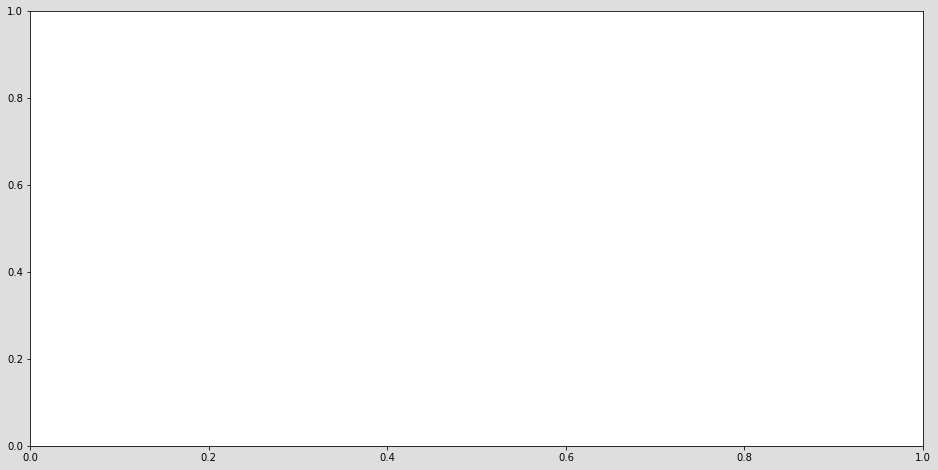

In [20]:
# set up the plotter

fig = plt.figure( figsize=(16.0,8.0),facecolor='#DEDEDE')
ax = fig.add_subplot(1,1,1)

ani = animation.FuncAnimation(fig, plot_data, interval=200)

#plot_data()

plt.show()



In [18]:
# Set up the broker

MQTT_SERVER = '192.168.50.14' #  MIT t4t mqtt broker or Scott's laptop via otle on Linksys
MQTT_GPS_SEND = "here_i_am" # this is the name of topic, like temp
MQTT_OTLE_REC = "over_early_q"

client_name = 'otle_processor'

ll_client = mqtt.Client(client_name)
ll_client.username_pw_set(username='t4t',password='GoBeavers5!') # set up authentication
ll_client.on_message = on_message
#ll_client.on_publish = on_publish        #attach function to callback
ll_client.reconnect_delay_set(min_delay=1, max_delay=1200) # need to change if races are longer than 20 minutes
ll_client.connect(MQTT_SERVER)

ll_client.subscribe(MQTT_GPS_SEND)  # subscribe to the 'here_i_am' messages


(0, 1)

In [21]:
ll_client.loop_start()  #use this line if you want to write any more code here

while True:
    while not q.empty():
        message = q.get()
        #print(message)
        msg = json.loads(message)

        df = df.append({"geometry":Point(msg["long"],msg["lat"]), "time": msg["time"], "course_t": msg["course_t"], "course_m": msg["course_m"], "speed": msg["speed"], "boat_id":msg["boat_id"], "skipper": msg["skipper"]}, ignore_index=True)
        df.geometry.crs="EPSG:4326"
    

    df = df.tail(20)

    utm = lonlat2UTM([df.geometry[0].x,df.geometry[0].y ])
    proj = "EPSG:" + str(utm)


    


KeyboardInterrupt: 